GENE TO DISEASE NAME GENERATOR USING DL & NLP

In [4]:
import pandas as pd
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv(r"D:\Gene to Disease Name Generator\cleaned_gene_cond.csv", header=0)
print(df.head())
print(df.columns)

  GeneID,AssociatedGenes,RelatedGenes,ConceptID,DiseaseName,SourceName,SourceID,DiseaseMIM,LastUpdated
0  144568,A2ML1,C1833692,Otitis,"media, susceptib...                                                  
1  53947,A4GALT,C3549485,Blood,"group, P1PK syste...                                                  
2  8086,AAAS,C0271742,Glucocorticoid,deficiency w...                                                  
3  79719,AAGAB,CN031225,Palmoplantar,"keratoderma...                                                  
4  16,AARS1,C4225361,Developmental,"and epileptic...                                                  
Index(['GeneID,AssociatedGenes,RelatedGenes,ConceptID,DiseaseName,SourceName,SourceID,DiseaseMIM,LastUpdated'], dtype='object')


In [6]:
raw_data = pd.read_csv("cleaned_gene_cond.csv", header=None)

# use regex to split on commas NOT inside quotes
# to avoid splitting gene names with commas in them
pattern = r''',(?=(?:[^"]*"[^"]*")*[^"]*$)'''

# apply to each row
records = raw_data[0].apply(lambda x: re.split(pattern, x)).tolist()

# convert to DataFrame
data = pd.DataFrame(records)

# set correct column names
data.columns = [
    'GeneID', 'AssociatedGenes', 'RelatedGenes', 'ConceptID',
    'DiseaseName', 'SourceName', 'SourceID', 'DiseaseMIM', 'LastUpdated'
]

# remove first row if duplicate header
if data.iloc[0,0] == 'GeneID':
    data = data.iloc[1:]

# remove extra quotes
data = data.apply(lambda x: x.str.replace('"','').str.strip())
data.to_csv("cleaned_data.csv", index=False)
# preview
print(data.head())
print(data.columns)


   GeneID AssociatedGenes RelatedGenes       ConceptID  \
1  144568           A2ML1     C1833692          Otitis   
2   53947          A4GALT     C3549485           Blood   
3    8086            AAAS     C0271742  Glucocorticoid   
4   79719           AAGAB     CN031225    Palmoplantar   
5      16           AARS1     C4225361   Developmental   

                        DiseaseName SourceName       SourceID DiseaseMIM  \
1          media, susceptibility to      MONDO  MONDO:0008162     166760   
2                group, P1PK system       NCBI       curation     111400   
3         deficiency with achalasia       NCBI       curation     231550   
4     keratoderma, punctate type 1A      MONDO  MONDO:0007858     148600   
5  and epileptic encephalopathy, 29      MONDO  MONDO:0014593     616339   

   LastUpdated  
1  Feb 16 2016  
2  Mar 10 2022  
3  Feb 16 2016  
4  May 21 2021  
5  Jan 21 2022  
Index(['GeneID', 'AssociatedGenes', 'RelatedGenes', 'ConceptID', 'DiseaseName',
       'Sour

In [7]:
print("Missing values in each column:")
print(data.isna().sum())

#standardize column names
data['DiseaseName'] = data['DiseaseName'].str.strip().str.lower()
data['AssociatedGenes'] = data['AssociatedGenes'].str.strip().str.upper()

#convert LastUpdated to datetime
data['LastUpdated'] = pd.to_datetime(data['LastUpdated'], errors='coerce')



Missing values in each column:
GeneID             0
AssociatedGenes    0
RelatedGenes       0
ConceptID          0
DiseaseName        0
SourceName         0
SourceID           0
DiseaseMIM         0
LastUpdated        0
dtype: int64


In [8]:
print(data.head())
print(data.info())

   GeneID AssociatedGenes RelatedGenes       ConceptID  \
1  144568           A2ML1     C1833692          Otitis   
2   53947          A4GALT     C3549485           Blood   
3    8086            AAAS     C0271742  Glucocorticoid   
4   79719           AAGAB     CN031225    Palmoplantar   
5      16           AARS1     C4225361   Developmental   

                        DiseaseName SourceName       SourceID DiseaseMIM  \
1          media, susceptibility to      MONDO  MONDO:0008162     166760   
2                group, p1pk system       NCBI       curation     111400   
3         deficiency with achalasia       NCBI       curation     231550   
4     keratoderma, punctate type 1a      MONDO  MONDO:0007858     148600   
5  and epileptic encephalopathy, 29      MONDO  MONDO:0014593     616339   

  LastUpdated  
1  2016-02-16  
2  2022-03-10  
3  2016-02-16  
4  2021-05-21  
5  2022-01-21  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10069 entries, 1 to 10069
Data columns (total 9 

STEP 2 : EDA

In [9]:
print("Checking Unique Values:")
print("Unique Disease Name: ",data['DiseaseName'].nunique())
print("Unique Associated Genes: ",data['AssociatedGenes'].nunique())
print("Top 10 Most Frequent Disease Names:\n", data['DiseaseName'].value_counts().head(10))

print("Rows with AssociatedGenes == 'unknown':\n", data[data['AssociatedGenes'] == 'unknown'])

print("Rows with DiseaseName == 'unknown':\n", data[data['DiseaseName'] == 'unknown'])

print("LastUpdated Range: ", data['LastUpdated'].min(), "to", data['LastUpdated'].max())




Checking Unique Values:
Unique Disease Name:  5562
Unique Associated Genes:  4881
Top 10 Most Frequent Disease Names:
 DiseaseName
syndrome                     706
                             376
disease                      231
disorder of glycosylation    103
muscular dystrophy            89
genetic hearing loss          87
syndrome 1                    77
response                      75
pigmentosa                    74
cancer                        71
Name: count, dtype: int64
Rows with AssociatedGenes == 'unknown':
 Empty DataFrame
Columns: [GeneID, AssociatedGenes, RelatedGenes, ConceptID, DiseaseName, SourceName, SourceID, DiseaseMIM, LastUpdated]
Index: []
Rows with DiseaseName == 'unknown':
 Empty DataFrame
Columns: [GeneID, AssociatedGenes, RelatedGenes, ConceptID, DiseaseName, SourceName, SourceID, DiseaseMIM, LastUpdated]
Index: []
LastUpdated Range:  2016-02-16 00:00:00 to 2025-05-28 00:00:00


In [10]:
print("Random Sample of 5 Rows:\n", data.sample(5))


Random Sample of 5 Rows:
       GeneID AssociatedGenes RelatedGenes               ConceptID  \
9226    8398          PLA2G6     C0030567               Parkinson   
8562    3689           ITGB2     C0272187               Leukocyte   
3879   57192          MCOLN1     C2749050                   Lisch   
10007  10352           WARS2     C2751067  Parkinsonism-dystonia,   
5859    8879           SGPL1     C0007959     Charcot-Marie-Tooth   

                        DiseaseName SourceName       SourceID DiseaseMIM  \
9226                        disease      MONDO  MONDO:0005180         16   
8562            adhesion deficiency      MONDO  MONDO:0017570         16   
3879   epithelial corneal dystrophy      MONDO  MONDO:0010425     620763   
10007                     infantile      MONDO  MONDO:0013150         02   
5859                        disease      MONDO  MONDO:0015626        Feb   

      LastUpdated  
9226          NaT  
8562          NaT  
3879   2022-04-19  
10007         NaT  
58

In [11]:
print(data["DiseaseName"].head(20))

1                              media, susceptibility to
2                                    group, p1pk system
3                             deficiency with achalasia
4                         keratoderma, punctate type 1a
5                      and epileptic encephalopathy, 29
6                  hereditary diffuse, with spheroids 2
7                                disease axonal type 2n
8                                  8, nonphotosensitive
9                     progressive, with ovarian failure
10              oxidative phosphorylation defect type 8
11                                                     
12                                              disease
13                                           primary, 1
14                   recessive congenital ichthyosis 4b
15                   recessive congenital ichthyosis 4a
16    developmental disorder with poor growth and wi...
17                 lung disease due to abca3 deficiency
18                                        pigmen

CLASSIFIER

In [12]:
# combine columns into one input feature
data['combined_text'] = (
    data['GeneID'].astype(str) + ' ' +
    data['AssociatedGenes'].astype(str) + ' ' +
    data['RelatedGenes'].astype(str)
)

# define X and y
x = data['combined_text']
y = data['DiseaseName']


In [13]:
# count frequency of each disease name
disease_counts = data['DiseaseName'].value_counts()

# filter to keep only disease names with at least 2 samples
# small classes will not be useful for training
valid_diseases = disease_counts[disease_counts >= 2].index
filtered_data = data[data['DiseaseName'].isin(valid_diseases)].copy()

print(f"Classes retained: {len(valid_diseases)}")




Classes retained: 658


In [14]:
# recompute X and y
filtered_data['combined_text'] = (
    filtered_data['GeneID'].astype(str) + ' ' +
    filtered_data['AssociatedGenes'].astype(str) + ' ' +
    filtered_data['RelatedGenes'].astype(str)
)
x = filtered_data['combined_text']
y = filtered_data['DiseaseName']



In [15]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [16]:
print(x_train.shape, y_train.shape)
print(le.classes_[:5])


(4132,) (4132,)
['' '1' '10' '11' '12']


TOKENIZATION AND PADDING

In [17]:
# set max vocab size
vocab_size = 10000
maxlen = 20  # max length of the combined_text sequence

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

# convert to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# pad
x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen, padding='post')

print(x_train_pad.shape, x_test_pad.shape)

(4132, 20) (1033, 20)


In [18]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=maxlen),
    LSTM(64),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model.summary()

c:\Users\anami\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
history = model.fit(
    x_train_pad, y_train,
    validation_data=(x_test_pad, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.1143 - loss: 5.8728 - val_accuracy: 0.1365 - val_loss: 5.1981
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.1419 - loss: 5.2501 - val_accuracy: 0.1365 - val_loss: 5.1804
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.1362 - loss: 5.2668 - val_accuracy: 0.1365 - val_loss: 5.1765
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1342 - loss: 5.2010 - val_accuracy: 0.1365 - val_loss: 5.1753
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1413 - loss: 5.1675 - val_accuracy: 0.1365 - val_loss: 5.1756
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1443 - loss: 5.1918 - val_accuracy: 0.1365 - val_loss: 5.1807
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1332 - loss: 5.1929 - val_accuracy: 0.1365 - val_loss: 5.1751
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.1402 - loss: 5.1932 - val_accu

In [20]:
# get raw predictions (probabilities)
probs = model.predict(x_test_pad)

# get top-1 class
pred_classes = np.argmax(probs, axis=1)

# decode to disease names
pred_diseases = le.inverse_transform(pred_classes)

# show a few:
for i in range(6):
    print(f"Input: {x_test.iloc[i]}")
    print(f"True:  {le.inverse_transform([y_test[i]])[0]}")
    print(f"Pred:  {pred_diseases[i]}")
    print("---")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Input: 6444 SGCD C0340427
True:  familial dilated cardiomyopathy
Pred:  syndrome
---
Input: 7291 TWIST1 C0175699
True:  syndrome
Pred:  syndrome
---
Input: 7015 TERT C0265965
True:  congenita
Pred:  syndrome
---
Input: 2719 GPC3 C0796154
True:  syndrome type 1
Pred:  syndrome
---
Input: 1141 CHRNB2 C3696898
True:  dominant nocturnal frontal lobe epilepsy
Pred:  syndrome
---
Input: 348 APOE C0002395
True:  disease
Pred:  syndrome
---


In [21]:
all_classes = np.arange(len(le.classes_))

print(classification_report(y_test, pred_classes, labels=all_classes, zero_division=0))

print("Top-3 accuracy: ", top_k_accuracy_score(y_test, probs, k=3, labels=all_classes))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

In [22]:
print("Sample true labels:", y_test[:10])
print("Sample predicted labels:", pred_classes[:10])
print("Label encoder classes:", le.classes_)
# Model's not learning meaningful patterns (Majority class prediction/ Class Imbalance)
# 1.Use class weights to handle class imbalance
# 2.Reduce the number of classes

Sample true labels: [254 548 124 574 202 169 114 548 564 433]
Sample predicted labels: [548 548 548 548 548 548 548 548 548 548]
Label encoder classes: ['' '1' '10' '11' '12' '13' '14' '15' '15q13.3 microdeletion syndrome'
 '16' '18' '19' '1q21.1 deletion syndrome' '2' '2 diabetes mellitus' '23'
 '25' '27' '3' '3 nonsyndromic hearing loss and deafness'
 '3, primary infantile, b' '30' '33' '36' '4' '45' '49' '5' '6' '7' '8'
 '9' 'acid lipase deficiency' 'acid storage disease' 'acidemia' 'aciduria'
 'aciduria and homocystinuria' 'acyl-coa dehydrogenase deficiency'
 'addiction, susceptibility to' 'adenomatous polyposis 1'
 'adhesion deficiency' 'adrenal hyperplasia' 'afibrinogenemia'
 'agenesis-abnormal ossification of the vertebral bodies-persistent notochordal canal syndrome'
 'albinism' 'albinism type 1' 'albinism type 7' 'alport syndrome'
 'amegakaryocytic thrombocytopenia' 'amyloid neuropathy' 'amyloidosis'
 'amyotrophic lateral sclerosis' 'and chorioretinopathy'
 'and lange-nielsen 

Using Weights

In [23]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

model.fit(
    x_train_pad, y_train,
    validation_data=(x_test_pad, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights_dict
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.0523 - loss: 6.3977 - val_accuracy: 0.0039 - val_loss: 6.4223
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0290 - loss: 6.6141 - val_accuracy: 0.1307 - val_loss: 5.7357
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.1133 - loss: 6.4635 - val_accuracy: 0.0707 - val_loss: 5.7275
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.1151 - loss: 5.8087 - val_accuracy: 0.0174 - val_loss: 5.9510
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0740 - loss: 5.7220 - val_accuracy: 0.0523 - val_loss: 5.5630
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0726 - loss: 5.5656 - val_accuracy: 0.0523 - val_loss: 5.5461
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0933 - loss: 5.3659 - val_accuracy: 0.0397 - val_loss: 5.6661
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0396 - loss: 5.2108 - val_accu

In [24]:
# Get predictions on the test set
probs = model.predict(x_test_pad)
pred_classes = np.argmax(probs, axis=1)

# Evaluate performance
from sklearn.metrics import classification_report, top_k_accuracy_score

all_classes = np.arange(len(le.classes_))
print(classification_report(y_test, pred_classes, labels=all_classes, zero_division=0))
print("Top-3 accuracy: ", top_k_accuracy_score(y_test, probs, k=3, labels=all_classes))

# Optionally, inspect a few predictions
for i in range(5):
    print(f"Input: {x_test.iloc[i]}")
    print(f"True:  {le.inverse_transform([y_test[i]])[0]}")
    print(f"Pred:  {le.inverse_transform([pred_classes[i]])[0]}")
    print("---")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.0

2. BROAD DISEASE CATEGORY CLASSIFICATION

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Step 1: Prepare the disease name text
text_data = data['DiseaseName'].fillna("")

# Step 2: Vectorize using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text_data)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=15, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

# Step 4: Map cluster IDs to category labels
cluster_to_category = {
    0: "Sensory - Microphthalmia",
    1: "Generic Syndrome",
    2: "Other",
    3: "Storage/Metabolic",
    4: "Neurological - Susceptibility",
    5: "Reproductive",
    6: "Musculoskeletal - Dystrophy",
    7: "Metabolic Deficiencies",
    8: "Neurological - Epilepsy",
    9: "Respiratory - Ciliary Dyskinesia",
    10: "Cardiovascular - Cardiomyopathies",
    11: "Sensory - Hearing Loss",
    12: "Skeletal Disorders",
    13: "Myopathies",
    14: "Mitochondrial / Metabolic"
}

# Step 5: Create human-readable labels
data['ClusterCategory'] = data['Cluster'].map(cluster_to_category)

In [26]:
print(data.columns)
print(data["Cluster"].head(5))

Index(['GeneID', 'AssociatedGenes', 'RelatedGenes', 'ConceptID', 'DiseaseName',
       'SourceName', 'SourceID', 'DiseaseMIM', 'LastUpdated', 'combined_text',
       'Cluster', 'ClusterCategory'],
      dtype='object')
1     1
2     1
3     1
4    13
5     1
Name: Cluster, dtype: int32


In [27]:
print(data["Cluster"])

1         1
2         1
3         1
4        13
5         1
         ..
10065     1
10066     9
10067     1
10068     1
10069     1
Name: Cluster, Length: 10069, dtype: int32


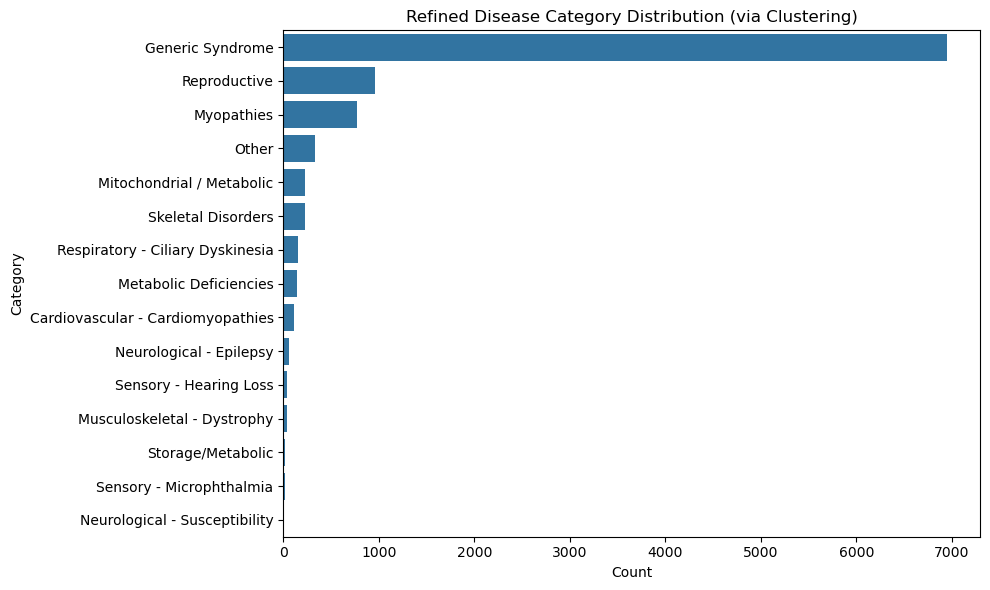

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(y=data["ClusterCategory"], order=data["ClusterCategory"].value_counts().index)
plt.title("Refined Disease Category Distribution (via Clustering)")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


In [29]:
# Use refined cluster-based categories for training
x = data['combined_text']
y = data['ClusterCategory']  # This now has more meaningful categories

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Tokenize and pad
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen, padding='post')


In [30]:
num_classes = len(le.classes_)  # Important: matches the number of cluster categories

model = Sequential([
    Embedding(vocab_size, 128, input_length=maxlen),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

c:\Users\anami\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
history = model.fit(
    x_train_pad, y_train,
    validation_data=(x_test_pad, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6971 - loss: 1.3732 - val_accuracy: 0.6897 - val_loss: 1.2438
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6844 - loss: 1.2646 - val_accuracy: 0.6897 - val_loss: 1.2488
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6873 - loss: 1.2405 - val_accuracy: 0.6966 - val_loss: 1.1678
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7397 - loss: 1.0213 - val_accuracy: 0.7254 - val_loss: 0.9964
Epoch 5/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7851 - loss: 0.8618 - val_accuracy: 0.7488 - val_loss: 0.9428
Epoch 6/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8149 - loss: 0.6735 - val_accuracy: 0.7408 - val_loss: 0.9609
Epoch 7/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8531 - loss: 0.5608 - val_accuracy: 0.7607 - val_loss: 0.9573
Epoch 8/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8693 - loss: 0.5016 - val_acc

In [32]:
# Predict probabilities
probs = model.predict(x_test_pad)
pred_classes = np.argmax(probs, axis=1)

# Classification report
print(classification_report(y_test, pred_classes, target_names=le.classes_))




63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
                                   precision    recall  f1-score   support

Cardiovascular - Cardiomyopathies       0.48      0.52      0.50        23
                 Generic Syndrome       0.83      0.92      0.87      1389
           Metabolic Deficiencies       0.90      0.64      0.75        28
        Mitochondrial / Metabolic       0.30      0.07      0.11        46
      Musculoskeletal - Dystrophy       1.00      0.38      0.55         8
                       Myopathies       0.22      0.25      0.23       155
          Neurological - Epilepsy       0.75      0.50      0.60        12
    Neurological - Susceptibility       0.00      0.00      0.00         2
                            Other       0.98      0.83      0.90        66
                     Reproductive       0.77      0.46      0.57       193
 Respiratory - Ciliary Dyskinesia       1.00      0.58      0.73        31
           Sensory - Hearing Loss       0.50      0.22      

c:\Users\anami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Top-3 accuracy
print("Top-3 accuracy: ", top_k_accuracy_score(y_test, probs, k=3))

Top-3 accuracy:  0.9041708043694141


In [34]:
top_3_indices = np.argsort(probs, axis=1)[:, -3:][:, ::-1]  # Top 3

for i in range(15):
    input_text = x_test.iloc[i]
    true_label = le.inverse_transform([y_test[i]])[0]

    pred_probs = probs[i]
    top_k = np.argsort(pred_probs)[-3:][::-1]  # top 3 indices
    top_k_probs = pred_probs[top_k]
    top_k_labels = le.inverse_transform(top_k)

    print(f"Input: {input_text}")
    print(f"True Category: {true_label}")
    print("Top-3 Predictions:")
    for j in range(3):
        print(f"  {j+1}. {top_k_labels[j]} (Prob: {top_k_probs[j]:.3f})")

    #  If confidence gap is small
    if top_k_probs[0] - top_k_probs[1] < 0.1:
        print(f"⚠️ Model unsure between: {top_k_labels[0]} and {top_k_labels[1]}")

    print("-" * 50)


Input: 51524 TMEM138 C3280906
True Category: Generic Syndrome
Top-3 Predictions:
  1. Myopathies (Prob: 0.777)
  2. Reproductive (Prob: 0.157)
  3. Skeletal Disorders (Prob: 0.031)
--------------------------------------------------
Input: 5593 PRKG2 C5562030
True Category: Skeletal Disorders
Top-3 Predictions:
  1. Skeletal Disorders (Prob: 0.614)
  2. Mitochondrial / Metabolic (Prob: 0.123)
  3. Generic Syndrome (Prob: 0.067)
--------------------------------------------------
Input: 2523 FUT1 C1859408
True Category: Generic Syndrome
Top-3 Predictions:
  1. Generic Syndrome (Prob: 0.749)
  2. Myopathies (Prob: 0.161)
  3. Mitochondrial / Metabolic (Prob: 0.025)
--------------------------------------------------
Input: 5378 PMS1 C2936783
True Category: Reproductive
Top-3 Predictions:
  1. Reproductive (Prob: 0.977)
  2. Myopathies (Prob: 0.012)
  3. Skeletal Disorders (Prob: 0.004)
--------------------------------------------------
Input: 3119 HLA-DQB1 C0022336
True Category: Other
Top-

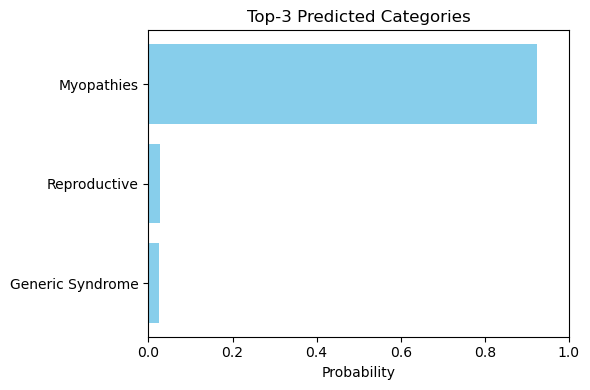

In [35]:

top_3_indices = np.argsort(probs, axis=1)[:, -3:][:, ::-1]  # Top 3

i = 50  # Choose any sample
top_3 = top_3_indices[i]
top_3_probs = probs[i][top_3]
top_3_labels = [le.classes_[j] for j in top_3]

plt.figure(figsize=(6, 4))
plt.barh(top_3_labels[::-1], top_3_probs[::-1], color='skyblue')
plt.xlabel("Probability")
plt.title("Top-3 Predicted Categories")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


In [36]:
import pickle
import os

# Create model directory if it doesn't exist
os.makedirs("model", exist_ok=True)

# Save tokenizer
with open("model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save label encoder
with open("model/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)  # 'le' is your LabelEncoder instance

# Save the trained model
model.save("model/trained_model_2.keras")

print("✅ All files saved to 'model/' folder")


✅ All files saved to 'model/' folder
